In [2]:
%matplotlib inline
import numpy as np
from misc import *
import matplotlib.pyplot as plt

solar_mass_in_seconds = 4.92686088e-6

# Brief summary

In this example we will generate a reduced basis set for a simple two-parameter oscillating function - which corresponds to a simple (gravitational) waveform. The idea of a writing a function in terms of an orthonormal basis will be familiar. Perhaps the most common example is the Fourier series.

For many applications a Fourier series is a very conveinent representation. However, for certain applications the Fourier series might be very cumbersome: the number of terms in the series might be very large for the desired accuracy, or the series might not converge, for example. In such cases it would be useful to have a way of computing some kind of "well adapted" basis for the specific problem of interest. A common approach to this sort of problem is to use a singular value decomposition, or principle component analysis, to represent the space of functions. In these cases, the bases generated by the SVD or PCA can lead to very compact and accurate representations of a space of functions. However, such approaches are not guaranteed to be gobally optimal, and hence the repersentations may be more accurate in some parts of the function space than others. To generate a globally optimal basis (that is, where the representation errors are minimized everywhere over the function space) we will consider yet another approach, known as the 'reduced basis method'. 

Before proceeding, I'll give a short sumamry of how the method works. Essentially we want to find a highly accurate, compact representation of the space of waveforms - in practice we will construct the basis so that the reduced basis representation suffers from essentially no loss in precision. Not only does this method produce highly accurate bases, but the algorithm used to generate them converges exponentially, which is a neat feature. It is also totally application specific, so the bases produced are very well adapted to particular problems.

The space of waveforms is parameterized by two parameters; a mass and frequency. The reduced basis method works by first constructing a dense space of waveforms, distributed on the mass parameter, and discretely sampled in frequency. This "training space" is used in a greedy algorithm, which will select waveforms in this space to make up the basis: unlike SVD, Fourier, PCA etc..., the bases used in the reduced basis method are directly related to the functions we're trying to represent, and are therefore somewhat less abstract. In this case the bases will be an orthonormalized set of waveforms. 

The greedy algorithm selects the basis elements iteratively, and works as follows. On the zeroth iteration, one selects an arbitrary seed waveform: at this iteration, the reduced basis consists of one waveform - the seed waveform. For the first iteration, one then computes the projection error of this basis element with every waveform in the training space. The waveform in the training space which has the worst projection error with the basis is then added to the basis, and the basis is orthonormalized. On the second iteration, one computes the projection error of the two basis elements with every waveform in the training space, finds the waveform with the worst projection error, adds it to the basis and orthonormalizes. And so on for the third, fourth....iteraions. The algorithm is terminated once once the projection error of the $n^{th}$ iteration reaches some user-defined threshold. 

The input to the algorithm is a training space of m waveforms $\{h_j(M_c;f)\}_{j=1}^{m}$. The output is an orthonormal basis $\{e(f)_i\}_{i=1}^{n}$. The result is that we will be able to write the waveform as an expansion $h(Mc;f) = \sum_{i=1}^{n} \langle h(M_c;f), e_i(f) \rangle\,e_i(f)$. The coeffieicnts $\langle h(M_c;f), e_i(f) \rangle$ are the inner product of $h$ with the basis elements $e_i$.

In this note, I'll show how to build the reduced basis in practice. The waveform is shown in the cell directly below. It corresponds to a post-Newtonian gravitational waveform, but it's not important and I want to stress the generality of the approach: it can be applied to any parameterized function. 

In [3]:
def phase(f, Mc):

        phase = -np.pi/4. + ( 3./( 128. * pow(Mc*np.pi*f, 5./3.) ) )
        return phase

def htilde(f, Mc):
        Mc *= solar_mass_in_seconds
        htilde = pow(f, -7./6.) * pow(Mc,5./6.) * np.exp(1j*phase(f,Mc))
        return htilde

The parameters (f, Mc) are frequency and chirp mass. Before we generate the basis we need to decide on the range in parameter space that we will work in. The chirp mass range I'll work in will be $1.5 \leq M_c \leq 3$. I won't explain the exact choice of these values, 

In [4]:
Mc_min = 1.5
Mc_max = 3

Next I'll define the upper and lower frequencies of the waveforms: $f_{min} =40Hz$ and $f_{max} = 1024Hz$. Rather than have a uniformly sampled waveforms in this range, I've opted to create a frequency series at the Chebyshev-Gauss-Lobatto nodes in the frequency interval. The only reason for doing this is to make the greedy more efficient, but don't dwell on this as it will probably just obscure the main point of the example.

In [5]:
fmin = 40.
fmax = 1024.
fseries, df = chebyshev_gauss_lobatto_nodes_and_weights(fmin, fmax, 5000)
np.savetxt("fseries.dat", np.matrix(fseries))
np.savetxt("df.dat", np.matrix(df))

Next I'll define the parameters for the training space. I'll make a training space with 2000 waveforms. Rather than distribute the waveforms uniformly between $Mc_{min}$ and $Mc_{max}$, I'll distribute them uniformly between $Mc_{min}^{5/3}$ and $Mc_{max}^{5/3}$. This is because $Mc^{5/3}$ appears in the phase, and it will turn out to be a much more judicious way to make the training space. In particular, it will make this script run much faster on your laptop.

In [6]:
TS_size = 2000 # training space of TS_size number of waveforms
Mcs_5_over_3 = np.linspace(Mc_min**(5./3.), Mc_max**(5./3.), TS_size)
Mcs = Mcs_5_over_3**(3./5.)

Now I'll actually make the training space. For storage purposes I'll allocate it as a matrix whose rows correspond to waveforms distributed on $M_c$. The columns of the matrix are the frequency samples of the waveforms. In addition, I'll normalize all the waveforms: You don't have to do this last step, but it makes computing the projection errors in the next step more simple. 

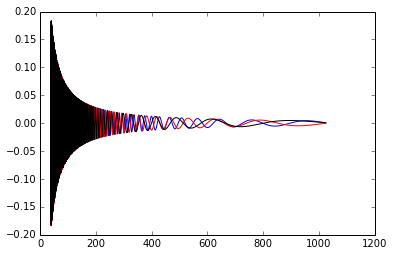

In [12]:
#### allocate memory for training space ####

TS = np.zeros(TS_size*len(fseries), dtype=complex).reshape(TS_size, len(fseries)) # store training space in TS_size X len(fseries) array

for i in range(TS_size):

        TS[i] = htilde(fseries, Mcs[i])
        # normalize
        TS[i] /= np.sqrt(abs(dot_product(df, TS[i], TS[i])))
        
plt.plot(fseries, TS[0], 'b', fseries, TS[345], 'r', fseries, TS[999], 'k')
plt.show()

The projection operation and the projection errors are defined as follows.

$\textbf{Projection}$: for a basis set $\{e_i\}_{i=1}^{n}$, the projection of $h$ onto the basis is defined as $\mathcal{P}h = \sum_{i=1}^{n}\langle h,e_i \rangle e_i$, where $\langle a, b \rangle$ is an inner product.

$\textbf{Projection coefficient}$: the coefficients $\langle h,e_i \rangle$ are the projection coefficients.

$\textbf{Projection error}$: the projection error $\sigma$ is the inner product of the residual of $h$ and it's projection: $\sigma = \langle (h - \mathcal{P}h), (h - \mathcal{P}h) \rangle.$

The stuff below is just some convenient storage for all the projections and projection coefficients.

In [9]:
#### Set up stuff for greedy#### 

# Allocate storage for projection coefficients of training space waveforms onto the reduced basis elements
proj_coefficients = np.zeros(TS_size*TS_size, dtype=complex).reshape(TS_size, TS_size)

# Allocate matrix to store the projection of training space waveforms onto the reduced basis 
projections = np.zeros(TS_size*len(fseries), dtype=complex).reshape(TS_size, len(fseries)) 

rb_errors = []

Now we will start the greedy algorithm to find the bases. We start by seeding the algorithm with the first basis element, chosen arbitrarily as the first waveform in the training set. This is stored in RB_matrix. For this example, I've set tolerance = 1e-12, which will be the target error of the complete basis to represent the training spcae, i.e., the waveforms written as an expansion in terms of the bases should be accurate to one part in $10^{12}$. The greedy algorithm will terminate once the maximum projection error - of the waveforms in the training space onto the basis - is less than or equal to the tolerance. 

Once the algorithm is done, the real and imaginary parts of the basis are stored in basis_re.dat and basis_im.dat respectively.

In [10]:
#### Begin greedy: see Field et al. arXiv:1308.3565v2 #### 

tolerance = 10e-12 # set maximum RB projection error

sigma = 1 # (2) of Algorithm 1. (projection error at 0th iteration)

rb_errors.append(sigma)

RB_matrix = [TS[0]] # (3) of Algorithm 1. (seed greedy algorithm (arbitrary))

iter = 0

while sigma >= tolerance: # (5) of Algorithm 1.

        # project the whole training set onto the reduced basis set
        projections = project_onto_basis(df, RB_matrix, TS, projections, proj_coefficients, iter) 

        residual = TS - projections
        # Find projection errors
        projection_errors = [dot_product(df, residual[i], residual[i]) for i in range(len(residual))]
        
        sigma = abs(max(projection_errors)) # (7) of Algorithm 1. (Find largest projection error)
        print sigma, iter
        index = np.argmax(projection_errors) # Find Training-space index of waveform with largest proj. error 

        rb_errors.append(sigma)
    
        #Gram-Schmidt to get the next basis and normalize

        next_basis = TS[index] - projections[index] # (9) of Algorithm 1. (Gram-Schmidt)
        next_basis /= np.sqrt(abs(dot_product(df, next_basis, next_basis))) #(10) of Alg 1. (normalize)

        RB_matrix.append(next_basis) # (11) of Algorithm 1. (append reduced basis set)

        iter += 1

np.savetxt("basis_re.dat", np.matrix(RB_matrix).real)
np.savetxt("basis_im.dat", np.matrix(RB_matrix).imag)


0.999999241668 0
0.999994078217 1
0.9999774499 2
0.999972102471 3
0.999918801587 4
0.999902381676 5
0.999892921339 6
0.999878266446 7
0.999728621559 8
0.999694384117 9
0.999668342339 10
0.999662948028 11
0.999600037664 12
0.999547536158 13
0.999535383884 14
0.999488461829 15
0.999108401543 16
0.999063152081 17
0.999021063456 18
0.999009283125 19
0.998946575882 20
0.998819174931 21
0.998764869193 22
0.998736976334 23
0.998734916486 24
0.998670876592 25
0.998605588564 26
0.998514900877 27
0.99833820221 28
0.998326726888 29
0.998057795312 30
0.997948062819 31
0.9976008618 32
0.99730867218 33
0.997207783394 34
0.997181846323 35
0.996934160184 36
0.996912334916 37
0.99674980563 38
0.996663316756 39
0.996541616635 40
0.996525195364 41
0.996335550612 42
0.996254749287 43
0.996241954559 44
0.996193395256 45
0.996096732692 46
0.996013008518 47
0.99591998356 48
0.995896468555 49
0.995642124822 50
0.995558338207 51
0.995543122663 52
0.995524809542 53
0.995428159936 54
0.995361946759 55
0.99527010

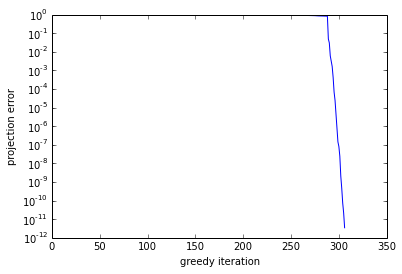

In [15]:
plt.plot(rb_errors)
plt.yscale('log')
plt.xlabel('greedy iteration')
plt.ylabel('projection error')
plt.show()

The above plot shows the projection error as a function of the greedy iteration. Notice that the errors hover around 1 for most of the algorithm and at some point decrease rapidly in only a few iterations. This feature is common, and corresponds to the exponential convergence promised earlier.
We should now check that the basis is as good as we hope: while the basis is already accurate to the 1e-12 level for approximating the training set, we should also check that it's accurate at describing waveforms which are in the Mc interval we considered, but which were not in the training space. To do this, I'll generate a new random training space in the Mc interval, and look at the projection errors of the reduced basis on the random training space. 

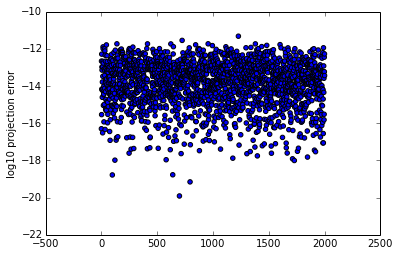

In [26]:
#### Error check ####

TS_rand_size = 2000

TS_rand = np.zeros(TS_rand_size*len(fseries), dtype=complex).reshape(TS_rand_size, len(fseries)) # Allocate random training space

Mcs_5_over_3_rand = Mc_min**(5./3.) + np.random.rand(TS_rand_size) * ( Mc_max**(5./3.) - Mc_min**(5./3.)  )
Mcs_rand = pow(Mcs_5_over_3_rand, 3./5.)

for i in range(TS_rand_size):

        TS_rand[i] = htilde(fseries, Mcs_rand[i])
        # normalize
        TS_rand[i] /= np.sqrt(abs(dot_product(df, TS_rand[i], TS_rand[i])))


### find projection errors ###
iter = 0
proj_rand = np.zeros(len(fseries), dtype=complex)
proj_error = []

for h in TS_rand:

        while iter < len(RB_matrix):

                proj_coefficients_rand = dot_product(df, RB_matrix[iter], h)
                proj_rand += proj_coefficients_rand*RB_matrix[iter]

                iter += 1

        residual = h - proj_rand
        projection_errors = abs(dot_product(df, residual, residual))
        proj_error.append(projection_errors)
        proj_rand = np.zeros(len(fseries), dtype=complex)
        
        iter = 0
        
plt.scatter(np.linspace(0, len(proj_error), len(proj_error)), np.log10(proj_error))
plt.ylabel('log10 projection error')
plt.show()

and you can see that the projection errors are all less than or around 1e-12, as we wanted!